# Analisis de errores

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

from py_aocg.ifta.algorithms import GS_scalar_Fresnel

number of processors: 8
total memory        : 7.5 Gb
available memory    : 28 %
max frequency       : 4000 GHz
py_aocg
number of processors: 8
total memory        : 7.5 Gb
available memory    : 28 %
max frequency       : 4000 GHz


## Mask

In [3]:
num_x=256
num_y=256
DOE_size=20*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

In [4]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()
# source.gauss_beam(r0=(0,0), w0=2500*mm, z0=0.0)

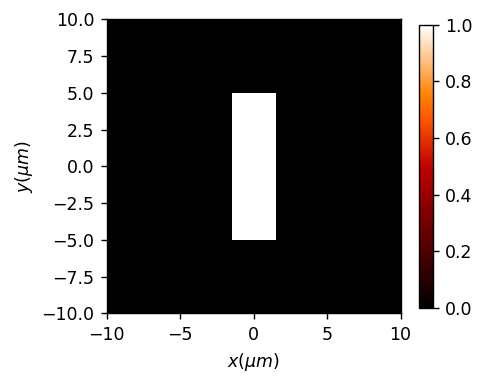

In [5]:
target=Scalar_mask_XY(x,y,wavelength)
target.image('mascara1024.png')

target.square(r0=(0,0), size=(3,10), angle=0)


target.draw(has_colorbar='vertical');

## Direct propagation

In [6]:
z_distance=3*um
u1 = target.RS(z=z_distance, verbose=True)
I1=np.abs(u1.u)**2

Good result: factor 5.83


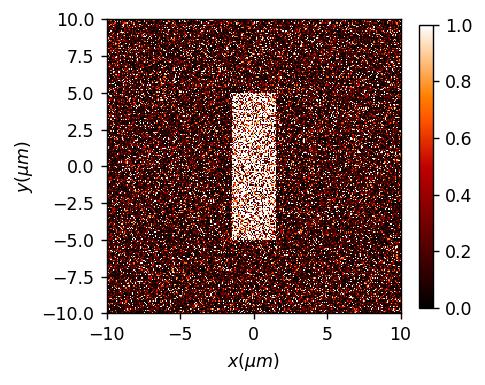

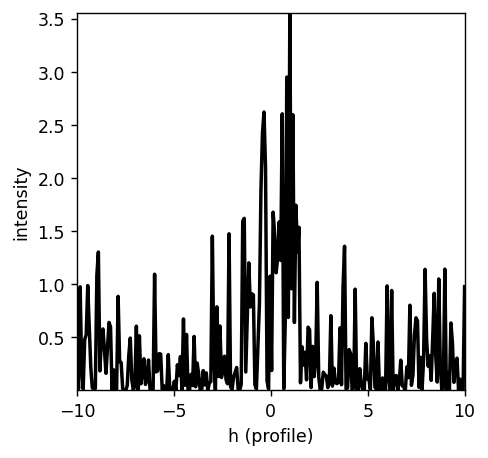

In [226]:
u2=deepcopy(target)
u2.u=u2.u+np.random.normal(0,0.5,size=u2.u.shape)
u2.draw(has_colorbar='vertical')
u2.draw_profile([-10,0], [10,0]);

2.0000000000000004

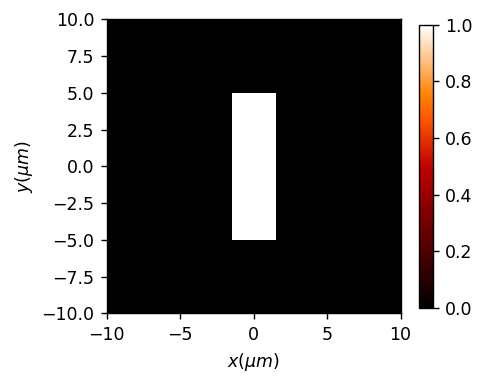

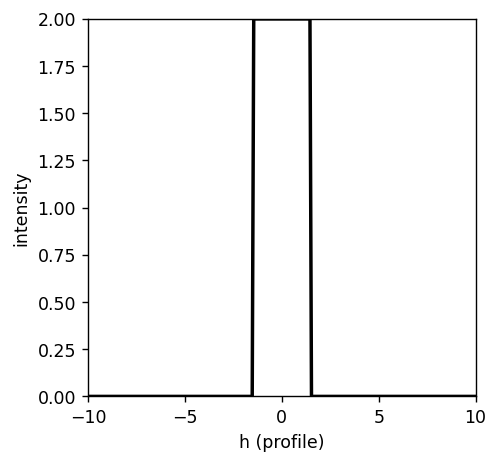

In [227]:
u3=deepcopy(target)
u3.u=np.sqrt(2)*u3.u
u3.draw(has_colorbar='vertical')
u3.draw_profile([-10,0], [10,0]);

u3.intensity().max()

# Definiciones

In [12]:
def mnse(I_result, I_target):
    """
    Computer the error as the average difference of the absolute value between of the intensity at target and the intensity at the result.

    Parameters:
        I_result (numpy.array): intensity produced by the algorithms
        I_target (numpy.array): intentisty at target
        is_balanced (bool): If True, perform the comparison using a proportion parameter to avoid different intensity levels

    Reference:
        K. Jahn and N. Bokor, “Intensity control of the focal spot by vectorial beam shaping,” Opt. Commun., vol. 283, no. 24, pp. 4859–4865, 2010, doi: 10.1016/j.optcom.2010.07.030.
        Similar to Ec. 17

    Returns:
        error: Mean difference between result and target.

    """

    error = np.sqrt(
        ((I_result / I_result.sum() - I_target / I_target.sum())**2).mean())

    return error * 100

In [13]:
def mean_square_error(result, target):
    '''
    Mean Square error of the designed DOE.

    Parameters:
    result (Scalar_mask XY or intensity): field or intensity distribution obtained with IFTA algorithm.
    target (Scalar_mask XY): field or intesity distribution of target

    Return:
    (float) Mean square error of the DOE.

    Reference:
    Jahn, K., &#38; Bokor, N. (2010). Intensity control of the focal spot by vectorial beam shaping. Optics Communications, 283 (24), 4859–4865.
    https://doi.org/10.1016/j.optcom.2010.07.030
    '''

    if isinstance(target, Scalar_source_XY) or isinstance(
            target, Scalar_field_XY) or isinstance(target, Scalar_mask_XY):

        max_result = (np.abs(result.u)**2).max()
        max_target = (np.abs(target.u)**2).max()

        result_normalize = (np.abs(result.u)**2) / max_result
        target_normalize = (np.abs(target.u)**2) / max_target

    else:
        max_result = result.max()
        max_target = target.max()

        result_normalize = result / max_result
        target_normalize = target / max_target

    NMSE = 1 / 4 * (((result_normalize - target_normalize)**2).mean())

    return NMSE * 100

In [14]:
def parameters_IFTA(result,
                    target,
                    diffraction_eff=True,
                    std=True,
                    NMSE=True,
                    verbose=True):
    """
    Quality parameters of IFTA algorithm. Using this function we could calculate the diffraction efficiency, standard_deviation and mean_square_error of the designed DOE.

    Parameters:
    result (Scalar_mask XY): Intensity distribution obtained with IFTA algorithm.
    target (Scalar_mask XY): Target intesity distribution
    diffraction_eff (bool): True if you want to calculate the diffraction_eff of the designed DOE. Default: True
    std (bool): True if you want to calculate the standard deviation of the designed DOE. Default: True
    NMSE (bool): True if you want to calculate the mean square error of the designed DOE. Default: True
    info_text (bool): If True the parameters appear with its name. If False the parameters appear as floats for use in a plot. Default: True


    Return:
    (list of strs or list of floats)  Quality parameters of the designed DOE.


    Reference (Diffraction Efficiency and Mean square error):
    Jahn, K., &#38; Bokor, N. (2010). Intensity control of the focal spot by vectorial beam shaping. Optics Communications, 283 (24), 4859–4865.
    https://doi.org/10.1016/j.optcom.2010.07.030

    """

    parameters = []

    if diffraction_eff:
        eff = diffraction_efficiency(result, target)
        parameters.append(eff)

        if verbose:
            print('Diffraction efficiency = {:.6f}'.format(eff))

    if std:
        std = standard_deviation(result, target)
        parameters.append(std)
        if verbose:
            print('Standard deviation = {:.6f}'.format(std))

    if NMSE:
        NMSE = mean_square_error(result, target, percentage=False)
        parameters.append(NMSE)

        if verbose:
            NMSE = mean_square_error(result, target)
            print('Mean Square error = {}'.format(NMSE))

    return parameters

# Comparaciones

## __condition_fields

In [165]:
def __condition_fields(result, target, mask=None, invert_mask=False, is_balanced=False):
    
    if not isinstance(result, (np.ndarray,)):
        result = np.abs(result.u)**2
        
    if not isinstance(target, (np.ndarray,)):
        target = np.abs(target.u)**2
        
    print(is_balanced)
    if is_balanced is True:
        print(is_balanced)
        factor = target.mean()/result.mean()
        result = result*factor
        print("factor: ", factor)
        
    if mask is None:
        return result, target, np.ones_like(result)
        
        
    if not isinstance(mask, (np.ndarray,)):
        mask = np.abs(mask.u)**2
        mask = mask/mask.max()
        
    if invert_mask:
        mask=1-mask
        
        
        
    return result, target, mask
        
    

In [166]:
I_result, I_target,_ = __condition_fields(target, target, None)
I_result.shape, I_target.shape


False


((256, 256), (256, 256))

False


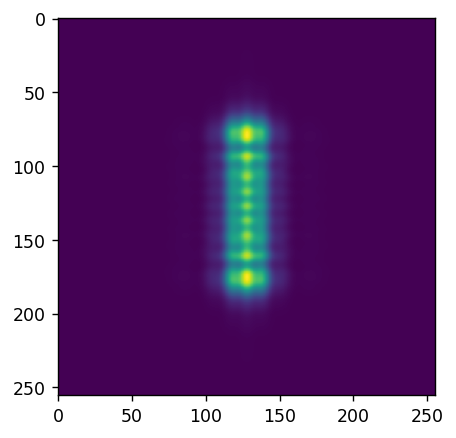

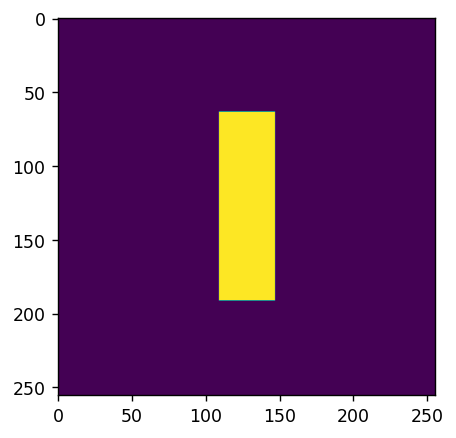

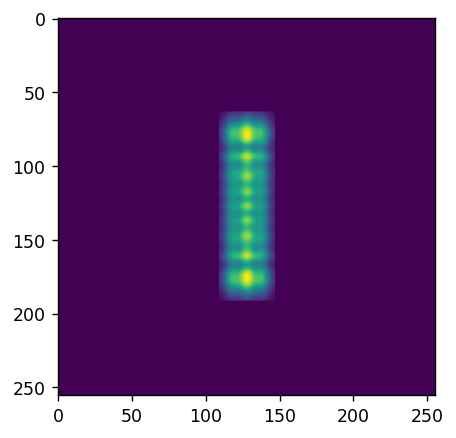

In [167]:
I_result, I_target, I_mask = __condition_fields(u1, target, target)
I_result.shape, I_target.shape
plt.figure(); plt.imshow(I_result)
plt.figure(); plt.imshow(I_target)
plt.figure(); plt.imshow(I_target*I_result)


False


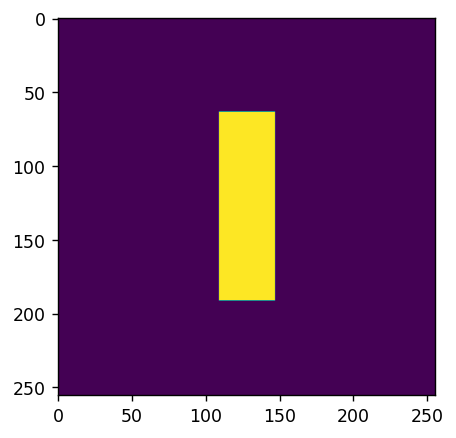

In [168]:
I_result, I_target, I_mask= __condition_fields(I_result, I_target, I_target)
I_result.shape, I_target.shape
plt.imshow(I_mask)

False


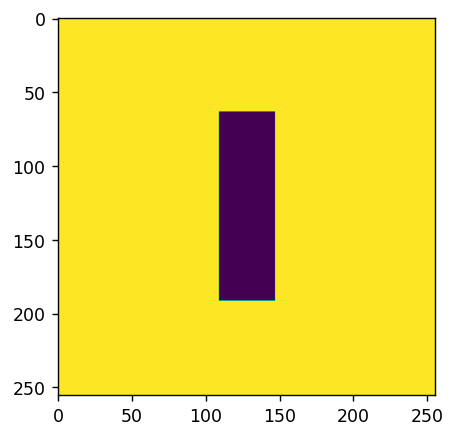

In [169]:
I_result, I_target, I_mask= __condition_fields(I_result, I_target, I_target, invert_mask=True)
I_result.shape, I_target.shape

plt.imshow(I_mask)

## compute_error

In [177]:

def compute_error(result, target, mask=None, invert_mask=False, is_balanced=False):
    """
    Computer the error as the average difference of the absolute value between of the intensity at target and the intensity at the result.

    Parameters:
        I_result (numpy.array): intensity produced by the algorithms
        I_target (numpy.array): intentisty at target
        is_balanced (bool): If True, perform the comparison using a proportion parameter to avoid different intensity levels


    Returns:
        error: Mean difference between result and target.

    """
    
    I_result, I_target, I_mask = __condition_fields(result, target, mask, invert_mask, is_balanced)
        
    plt.figure()
    plt.imshow(I_result)
    plt.figure()
    plt.imshow(I_target)
    plt.figure()
    plt.imshow(I_mask)
    error = (np.abs((I_result - I_target)*I_mask)).mean()

    return error


False


0.0

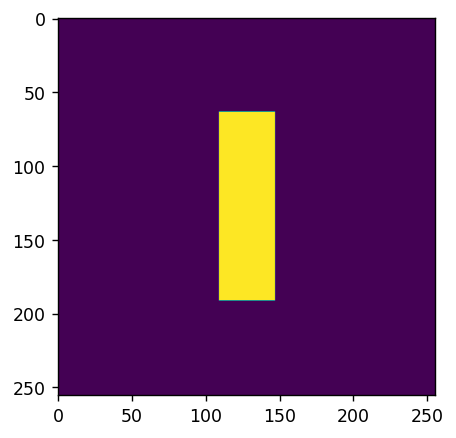

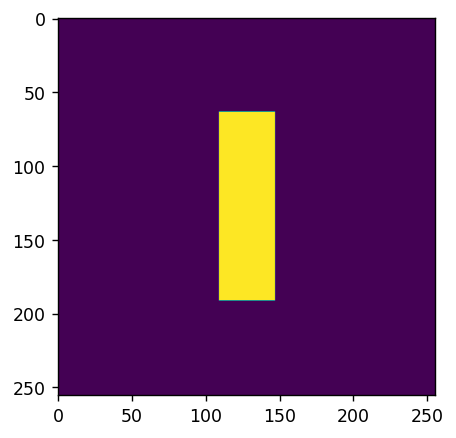

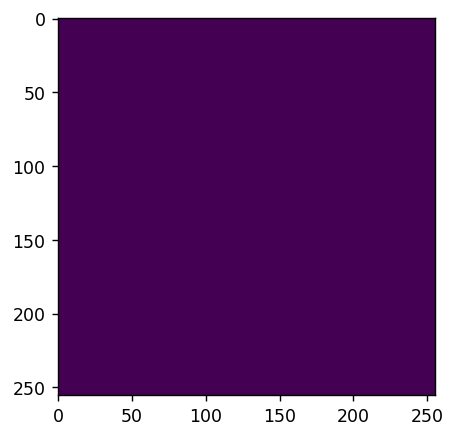

In [178]:
compute_error(target, target, None, invert_mask=False, is_balanced=False)

True
True
factor:  1.0587619029330029


0.026119171445781353

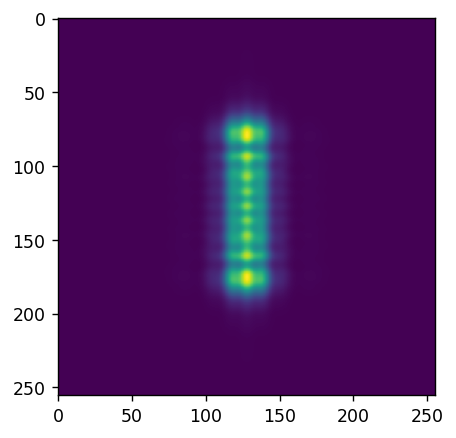

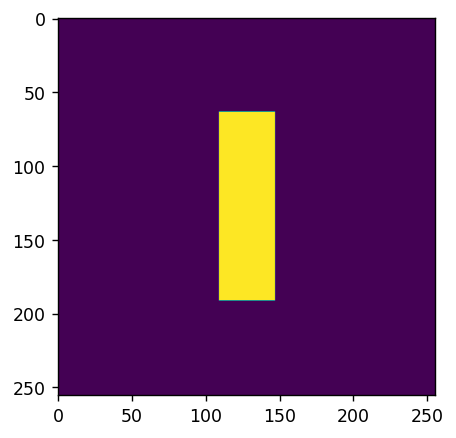

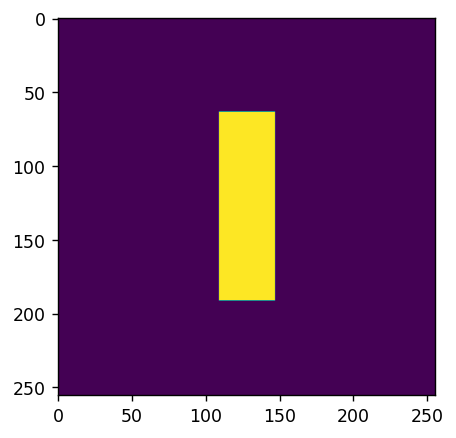

In [179]:
compute_error(u1, target, target, invert_mask=False, is_balanced=True)

False


0.025478132317929905

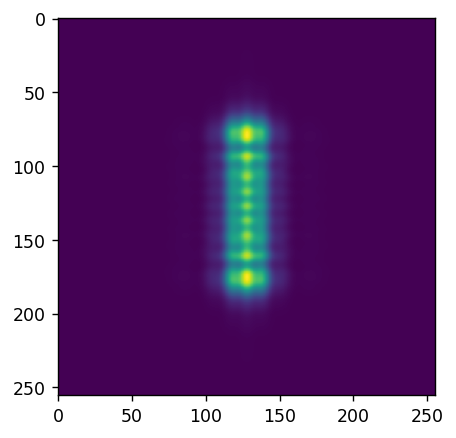

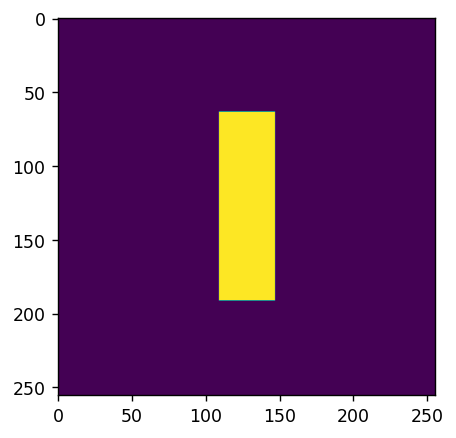

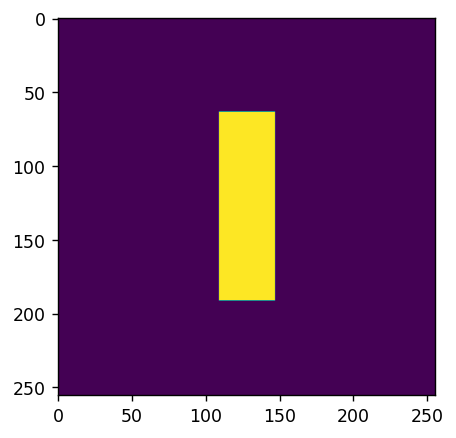

In [181]:
compute_error(u1, target, target, invert_mask=False, is_balanced=False)

True
True
factor:  0.49999999999999983


8.239936510889834e-18

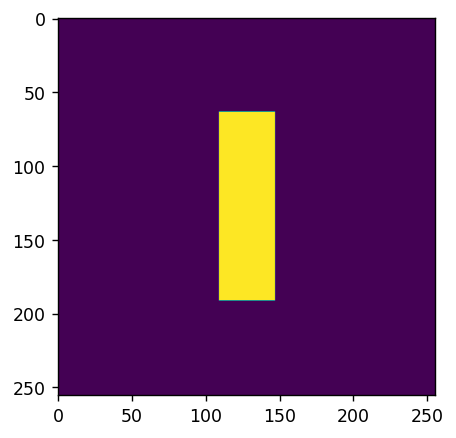

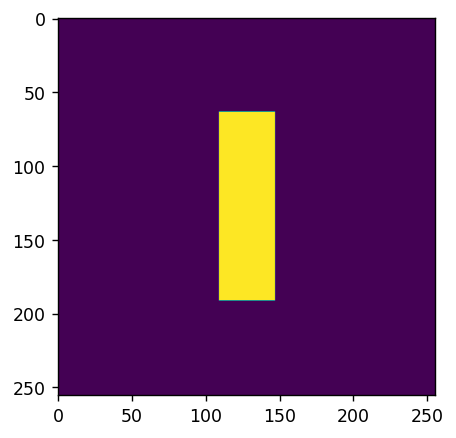

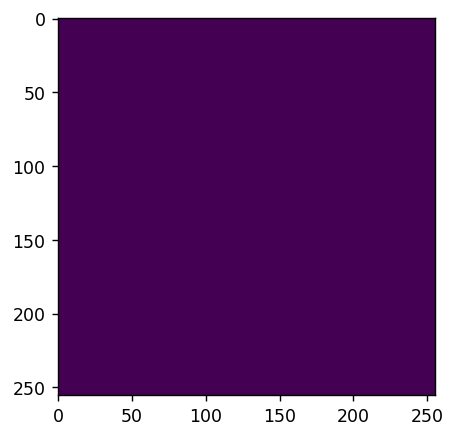

In [195]:
compute_error(u3, target, None, invert_mask=True, is_balanced=True)

False


0.009061653203889814

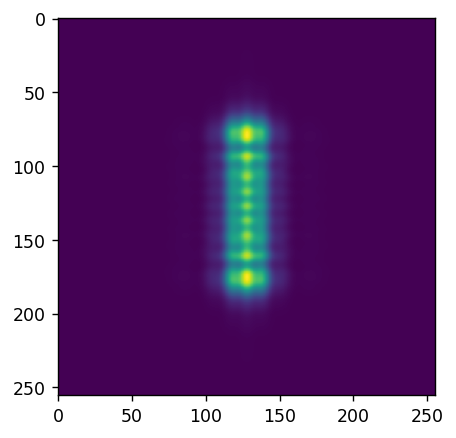

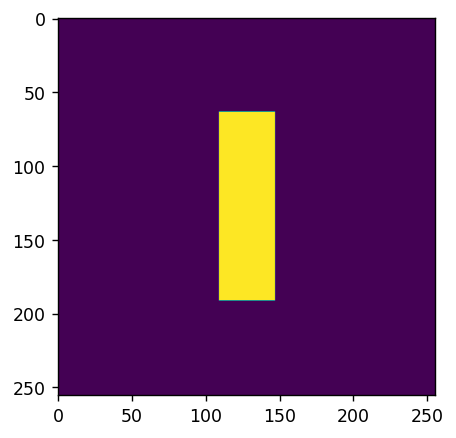

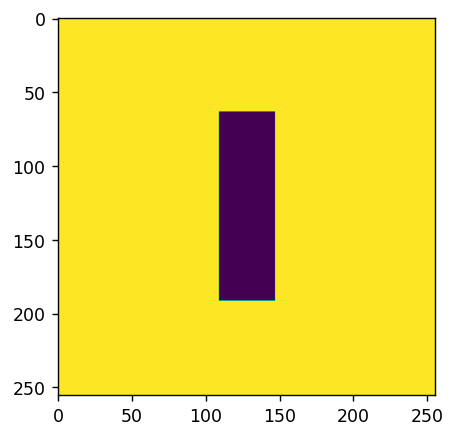

In [196]:
compute_error(u1, target, target, invert_mask=True, is_balanced=False)

In [92]:
compute_error(u2, target, None, invert_mask=False, is_balanced=False)

False
False


0.021213411952426552

In [93]:
compute_error(u2, target, target, invert_mask=False, is_balanced=False)

False
False


0.011927829481294585

In [94]:
compute_error(u2, target, target, invert_mask=True, is_balanced=False)

False
False


0.00928558247113197

In [97]:
compute_error(u2, target, invert_mask=False,  is_balanced=False)

False
False


0.021213411952426552

In [98]:
compute_error(u2, target, target,  is_balanced=True)

True
True
True
factor:  0.8809064192292633


0.012759806497586183

In [99]:
compute_error(u3, target, None, is_balanced=False)

False
False


0.07421875000000003

In [100]:
compute_error(u3, target, None,  is_balanced=True)

True
True
True
factor:  0.49999999999999983


8.239936510889834e-18

In [101]:
compute_error(u3, target, target,  is_balanced=True)

True
True
True
factor:  0.49999999999999983


8.239936510889834e-18

## standard deviation

In [197]:
def standard_deviation(result, mask, invert_mask=False):
    '''
    Standard deviation of the designed DOE.

    Parameters:
    result (Scalar_mask XY): field or intensity distribution obtained with IFTA algorithm.
    target (Scalar_mask XY): field or intensity of the target.

    Return:
    (float): Standard deviation of the DOE
    '''

    I_result, I_target, I_mask = __condition_fields(result, target, mask, invert_mask, is_balanced=False)


    std = np.std(I_result[I_mask > 0.5])

    return std

In [198]:
standard_deviation(target,target)

False


0.0

In [202]:
standard_deviation(u1, target, invert_mask=False)

False


0.3943158712065695

In [203]:
standard_deviation(u1,target, invert_mask=True)

False


0.031691568095538684

In [204]:
standard_deviation(u2,target, invert_mask=False)

False


0.20260756308447825

In [205]:
standard_deviation(u2,target, invert_mask=True)

False


0.014119222866797147

In [206]:
standard_deviation(u3, target, invert_mask=False)

False


0.0

## Diffraction efficiency

In [223]:
def diffraction_efficiency(result, target, invert_mask=False):
    '''
    Diffraction efficiency of the designed DOE: Intensity(target_zone) / Intensity(total)

    Parameters:
    result (Scalar_mask XY): field or intensity distribution obtained with IFTA algorithm.
    target (Scalar_mask XY): field or intensity distribution of target.

    Return:
    (float): Diffraction efficiency of the DOE

    Reference:
    Jahn, K., &#38; Bokor, N. (2010). Intensity control of the focal spot by vectorial beam shaping. Optics Communications, 283 (24), 4859–4865.
    https://doi.org/10.1016/j.optcom.2010.07.030
    '''
        
    I_result, I_target, I_mask = __condition_fields(result, target, mask=target, invert_mask=invert_mask, is_balanced=False)
    
    print(I_result.mean(), I_target.mean(), I_mask.mean())
    
    I_region = I_result*I_mask
    I_total = I_result

    plt.imshow(I_region)

    diffraction_efficiency = I_region.mean() / I_total.mean()

    return diffraction_efficiency * 100

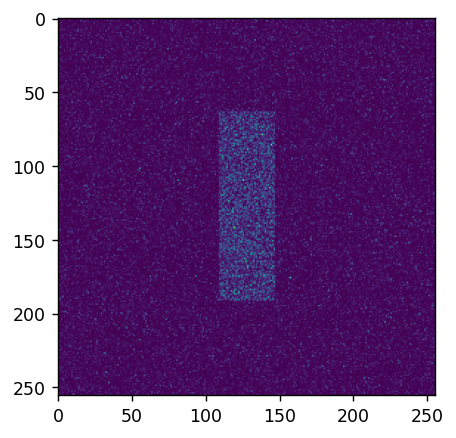

In [235]:
plt.imshow(np.abs(u2.u)**2);

False
0.32531305342022687 0.07421875 0.07421875


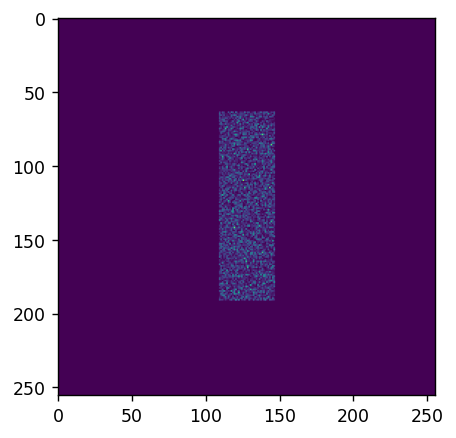

In [236]:
diffraction_efficiency(u2, I_target);

False
0.32531305342022687 0.07421875 0.92578125


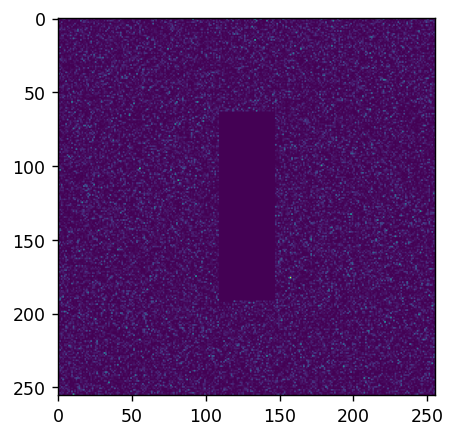

In [237]:
diffraction_efficiency(u2, I_target, invert_mask=True);